# 3. AO Performance Estimation: Strehl ratio

## 3.1 Introduction

Various merit functions are used to quantify the performance of an optical instrument, but in AO the Strehl ratio is the most commonly used.

It provides a measure of how the AO system is capable to compensate for aberrations.

The Strehl ratio is defined as the ratio of the peak intensity of the observed point spread function (PSF) to the peak intensity of the ideal diffraction-limited PSF:

$$
\text{SR}=\frac{\text{I}^{peak}_{meas}}{\text{I}^{peak}_{dl}}
$$

A Strehl ratio of 1 indicates a perfect correction at diffraction limint, while lower values reflect increasing degradation due to optical aberrations or incomplete AO correction.   

In this section we want to estimete the SR of the closed-loop psf on *Beta Pegasi*.  We remaind that the data has been collected with PAPYRUS NIR imager camera [C-RED3](https://andor.oxinst.com/products/c-red-series/c-red-3) camera.

Let's start by loading the needed modules and quickly the reduced the closed loop PSF image from the observations.

In [ ]:
!pip uninstall -y oao24
!pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from oao24.package_data import InfraredExampleData, VisibleExampleData
from oao24 import image_processing

In [ ]:
# backgroud reduction of closed-loop psf data
background_image = InfraredExampleData.get_camera_dark_data()
cl_raw_image_cube = InfraredExampleData.get_close_loop_data_cube()
ao_image = image_processing.make_master_image(cl_raw_image_cube, background_image)

We need to define the telescope and camera parameters that will be used in the following analysis, and select the region of interest.

In [ ]:
## defining pixel scale and diffraction limited resolution
RAD2ARCSEC=180/np.pi*3600
pupil_diameter = 1.52 
wavelength = 1.65e-6 # 1310e-9
# Plate scale is typically saved in the FITS image header
# or it can be calibrated using 2 sources of known distance
# Here we use the Papyrus nominal optical design values
# F/# = 23
# The DL PSF size in m on the focal is F/H * wavelength
cred3_pixel_in_meter = 15e-6
f_number =  23
telescope_focal_length = f_number * pupil_diameter
# so the size of the pixel in arcsec is 
pixel_scale_in_arcsec =cred3_pixel_in_meter / telescope_focal_length * RAD2ARCSEC 

# the DL size (=lambda/D) in units of arcsec or pixels are therefore
dl_size_in_arcsec = wavelength / pupil_diameter * RAD2ARCSEC 
dl_size_in_pixels = dl_size_in_arcsec / pixel_scale_in_arcsec

print("C-Red3 pixel scale: %g arcsec/pixel" % pixel_scale_in_arcsec)
print("DL PSF size: %g arcsec" % dl_size_in_arcsec)
print("DL PSF size: %g pixels" % dl_size_in_pixels)


In [5]:
## Selecting a ROI
star_roi = ao_image[240:296, 335:391]
star_roi_cut_index = (29, slice(15, 45))

## 3.2 From pupil mask to diffraction limited PSF 

To estimate the SR we need to compute the expected diffraction limited PSF.

We want to create a mask that represtent the telescope pupil and compute the PSF through a *Fourier Transform* (FT) as follows:
$$
\text{PSF} = |\text{FT}(\text{PUPIL})|^2
$$



To compute the diffraction limited psf, we can define a function like `compute_psf_dl`. To do so, we can use one of the class defined in `mask.py`, to reproduce a masked array that simulates the pupil of our telescope. 

In [6]:
from oao24.mask import AnnularMask

def compute_psf_dl(Npix, obs_radius_in_pix, wavelength, pupil_diameter, pixel_scale_in_arcsec):
    pupil = np.zeros((Npix,Npix))
    pupil_radius_in_pix = Npix/2
    

    pupil_mask_obj = AnnularMask(
        frameShape=pupil.shape,
        maskRadius=pupil_radius_in_pix,
        inRadius=obs_radius_in_pix)

    pupil_mask = pupil_mask_obj.mask()
    phase = np.ma.array(pupil, mask = pupil_mask)

    # computing transmitted electric field
    Ut = 1 * np.exp(1j * phase)
    Ut.fill_value = 0
    Ut.data[Ut.mask == True] = 0

    # padding transmitted electric field to match resulting px scale with the instrument pixel scale
    Npad = wavelength / pupil_diameter  * RAD2ARCSEC /  pixel_scale_in_arcsec
    print("Pupil padding %g" % Npad)
    padded_frame_size = int(np.round(Npix * Npad))
    padded_Ut = np.zeros((padded_frame_size, padded_frame_size), dtype=complex)
    padded_Ut[0 : Ut.shape[0], 0 : Ut.shape[1]] = Ut   

    plt.figure()
    plt.imshow(np.abs(padded_Ut))
    plt.colorbar()


    #computing psf
    dl_psf = np.abs(np.fft.fftshift(np.fft.fft2(padded_Ut)))**2
    plt.figure()
    plt.imshow(dl_psf)
    plt.colorbar()

    dl_psf_scale_in_arcsec = wavelength / pupil_diameter / Npad * RAD2ARCSEC

    return dl_psf, dl_psf_scale_in_arcsec


Now we can proceed to compute our expected diffraction limited PSF:

In [ ]:

Npix = 200
pupil_radius_in_pix = Npix/2
obstruction_radius_in_pix = 0.33*pupil_radius_in_pix
dl_psf, dl_psf_scale_in_arcsec = compute_psf_dl(Npix, obstruction_radius_in_pix, wavelength, pupil_diameter, pixel_scale_in_arcsec)
print("Computed DL PSF scale %g" % dl_psf_scale_in_arcsec)


To compare our measurements with the simulated PSF, we need to properly normalise the model. In this way, we can directly compare our measurments with our normalized model:

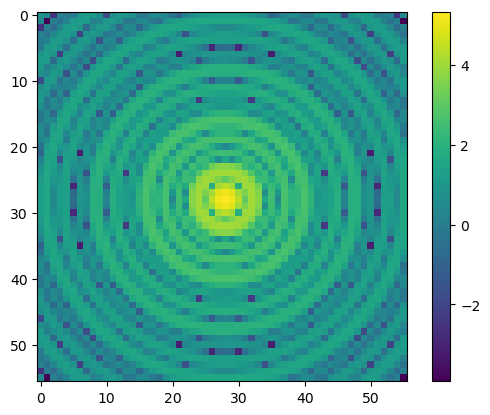

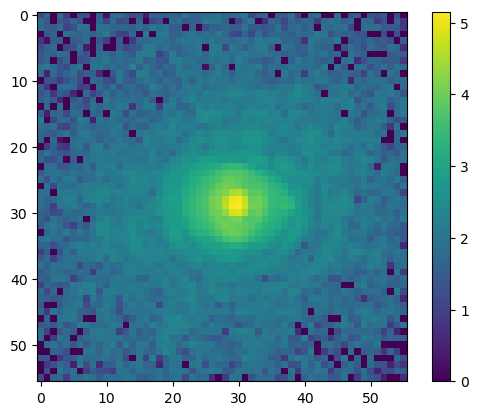

In [9]:

total_dl_flux = dl_psf.sum()
total_meas_flux = star_roi.sum()
dl_psf_norm = dl_psf * total_meas_flux/total_dl_flux
cc=(dl_psf_norm.shape[0]) // 2
dl_psf_norm_roi = dl_psf_norm[cc-28:cc+28, cc-28:cc+28]

plt.figure()
plt.imshow(np.log10(dl_psf_norm_roi))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(np.clip(star_roi,0,None)+1))
plt.colorbar()


Now, we got the measured and predicted PSF on the same scale. 

Finally, we compute the SR as the ratio of maximum of the 2 images, as in the following cells:

In [ ]:

print("Max(DL PSF normalized) %g" % dl_psf_norm_roi.max())
print("Max(Measured PSF) %g" % star_roi.max())
strehl_ratio = star_roi.max() / dl_psf_norm_roi.max()
print("SR: %g" % strehl_ratio)


plt.figure()
plt.plot(dl_psf_norm_roi[28,:], label='DL PSF')
plt.plot(star_roi[29,:], label='Measured PSF')
plt.legend()


## 3.3 Questions

However, this approach has several limitation, such us:
1. determination of the center of star roi
2. background subtraction is crucial to SR estimation
3. ... can you see any other ? :-)